In [1]:
from google.colab import files
uploaded = files.upload()

Saving train.json to train.json


In [22]:
# Import the libraries we'll use below.
import numpy as np
from matplotlib import pyplot as plt
import pandas as pd
import seaborn as sns  # for nicer plots
sns.set(style="darkgrid")  # default style
import plotly.graph_objs as plotly  # for interactive plots
import re
import string

import tensorflow as tf
from tensorflow import keras

from sklearn.model_selection import train_test_split

In [56]:
# create test and train sets
all_data = pd.read_json("train.json")
outcomes = all_data["requester_received_pizza"]
features = all_data.drop("requester_received_pizza", axis=1)

X_train, X_test, y_train, y_test = train_test_split(features, outcomes, test_size=0.1, random_state=6)

X_train.columns

Index(['giver_username_if_known',
       'number_of_downvotes_of_request_at_retrieval',
       'number_of_upvotes_of_request_at_retrieval', 'post_was_edited',
       'request_id', 'request_number_of_comments_at_retrieval', 'request_text',
       'request_text_edit_aware', 'request_title',
       'requester_account_age_in_days_at_request',
       'requester_account_age_in_days_at_retrieval',
       'requester_days_since_first_post_on_raop_at_request',
       'requester_days_since_first_post_on_raop_at_retrieval',
       'requester_number_of_comments_at_request',
       'requester_number_of_comments_at_retrieval',
       'requester_number_of_comments_in_raop_at_request',
       'requester_number_of_comments_in_raop_at_retrieval',
       'requester_number_of_posts_at_request',
       'requester_number_of_posts_at_retrieval',
       'requester_number_of_posts_on_raop_at_request',
       'requester_number_of_posts_on_raop_at_retrieval',
       'requester_number_of_subreddits_at_request',
  

In [4]:
# create a train/test set with only numeric fields
numeric_columns = ["number_of_downvotes_of_request_at_retrieval",
                   "number_of_upvotes_of_request_at_retrieval",
                   "post_was_edited",
                   "request_number_of_comments_at_retrieval",
                   "requester_account_age_in_days_at_request",
                   "requester_days_since_first_post_on_raop_at_request",
                   "requester_number_of_comments_at_request",
                   "requester_number_of_comments_in_raop_at_request",
                   "requester_number_of_posts_at_request",
                   "requester_number_of_subreddits_at_request",
                   "requester_upvotes_minus_downvotes_at_request",
                   "requester_upvotes_plus_downvotes_at_request"
]

In [5]:
X_train_numeric_only = X_train[numeric_columns]
X_test_numeric_only = X_test[numeric_columns]

In [6]:
number_of_features = X_train_numeric_only.shape[1]
model = keras.Sequential()
model.add(keras.layers.Dense(1,activation = 'sigmoid',input_dim = number_of_features))
model.compile(optimizer='adam', loss='binary_crossentropy')
model.fit(x = X_train_numeric_only, y = y_train, epochs=10, validation_split=0.1)

Epoch 1/10
103/103 [==============================] - 2s 7ms/step - loss: 35567708.0000 - val_loss: 22414800.0000
Epoch 2/10
103/103 [==============================] - 1s 6ms/step - loss: 29807664.0000 - val_loss: 18420018.0000
Epoch 3/10
103/103 [==============================] - 0s 4ms/step - loss: 23886204.0000 - val_loss: 14376199.0000
Epoch 4/10
103/103 [==============================] - 0s 4ms/step - loss: 18195872.0000 - val_loss: 10426367.0000
Epoch 5/10
103/103 [==============================] - 0s 3ms/step - loss: 12504009.0000 - val_loss: 6553214.0000
Epoch 6/10
103/103 [==============================] - 0s 3ms/step - loss: 6693656.5000 - val_loss: 2653142.0000
Epoch 7/10
103/103 [==============================] - 0s 3ms/step - loss: 1329994.7500 - val_loss: 34154.9219
Epoch 8/10
103/103 [==============================] - 0s 4ms/step - loss: 22669.5508 - val_loss: 1459.6794
Epoch 9/10
103/103 [==============================] - 0s 4ms/step - loss: 10412.5820 - val_loss: 9569.

In [7]:
y_train_pred_raw = model.predict(X_train_numeric_only)
y_train_pred = y_train_pred_raw > 0.5
y_test_pred_raw = model.predict(X_test_numeric_only)
y_test_pred = y_test_pred_raw > 0.5

13/13 [==============================] - 0s 2ms/step


In [8]:
y_test

2540     True
159     False
279     False
1563    False
1532    False
        ...  
1329    False
3780     True
1475    False
2534     True
1579    False
Name: requester_received_pizza, Length: 404, dtype: bool

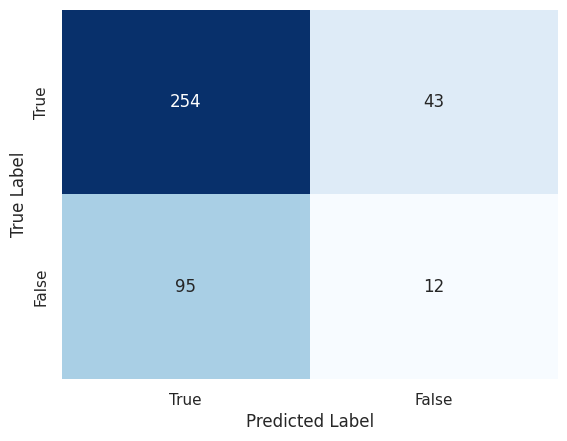

In [9]:
confusion_matrix = tf.math.confusion_matrix(y_test, y_test_pred)
label_names = [True, False]
# Use a heatmap plot to display it.
ax = sns.heatmap(confusion_matrix, annot=True, fmt='.3g', cmap='Blues',
                 xticklabels=label_names, yticklabels=label_names, cbar=False)

# Add axis labels.
ax.set(xlabel='Predicted Label', ylabel='True Label')
plt.show()

In [10]:
print("Train Accuracy:")
train_matches = sum(y_train.values == y_train_pred.flatten())
train_accuracy = train_matches / len(y_train.values)
print(round(train_accuracy, 4))
print("Test Accuracy:")
test_matches = sum(y_test.values == y_test_pred.flatten())
test_accuracy = test_matches / len(y_test.values)
print(round(test_accuracy, 4))

Train Accuracy:
0.6922
Test Accuracy:
0.6584


In [89]:
# Now lets add embeddings
def build_embeddings_model(average_over_positions=False,
                           vocab_size=1000,
                           sequence_length=20,
                           embedding_dim=2):
  """Build a tf.keras model using embeddings."""
  # Clear session and remove randomness.
  tf.keras.backend.clear_session()
  tf.random.set_seed(0)

  model = tf.keras.Sequential()
  model.add(tf.keras.layers.Embedding(
      input_dim=vocab_size,
      output_dim=embedding_dim,
      input_length=sequence_length)
  )

  if average_over_positions:
    # This layer averages over the first dimension of the input by default.
    model.add(tf.keras.layers.GlobalAveragePooling1D())
  else:
    # Concatenate.
    model.add(tf.keras.layers.Flatten())
  model.add(tf.keras.layers.Dense(
      units=1,                     # output dim (for binary classification)
      activation='sigmoid'         # apply the sigmoid function!
  ))

  model.compile(loss='binary_crossentropy',
                optimizer='adam',
                metrics=['accuracy'])

  return model

def plot_history(history):
  plt.ylabel('Loss')
  plt.xlabel('Epoch')
  plt.xticks(range(0, len(history['loss'] + 1)))
  plt.plot(history['loss'], label="training", marker='o')
  plt.plot(history['val_loss'], label="validation", marker='o')
  plt.legend()
  plt.show()

In [76]:
def limit_vocab(sequences, max_token_id, oov_id=2):
  """Replace token ids greater than or equal to max_token_id with the oov_id."""
  reduced_sequences = np.copy(sequences)
  reduced_sequences[reduced_sequences >= max_token_id] = oov_id
  return reduced_sequences

def preprocess_text(text):
  # Remove punctuation
  text = text.translate(str.maketrans('', '', string.punctuation))

  # Convert to lowercase
  text = text.lower()

  # Tokenize the text into individual words
  words = re.findall(r'\b\w+\b', text)

  return words

In [65]:
# text only
all_data_text = all_data['request_text'].apply(preprocess_text)
all_data_text.shape

(4040,)

In [58]:
# Create a vocabulary of all the unique words in the text data
vocab = set()
for text in all_data_text:
    vocab.update(text)

# Create a word-to-index mapping
word_to_index = {}
for i, word in enumerate(vocab):
    word_to_index[word] = i

In [81]:
all_data_text_vectorized = all_data_text.apply(lambda x: [word_to_index[word] for word in x])
all_data_result = all_data['requester_received_pizza'].astype(int)
X_train_text, X_test_text, y_train_text, y_test_text = train_test_split(all_data_text_vectorized, all_data_result, test_size=0.1, random_state=6)

In [85]:
def pad_data(sequences, max_length):
  # Keras has a convenient utility for padding a sequence.
  # Also make sure we get a numpy array rather than an array of lists.
  return np.array(list(
      tf.keras.preprocessing.sequence.pad_sequences(
          sequences, maxlen=max_length, padding='post', value=0)))

X_train_text_padded = pad_data(X_train_text, max_length=300)
# print(X_train_text.shape)
# print(X_train_text_padded.shape)
# print(len(X_train_text[1]))
# print(len(X_train_text_padded[1]))
# print(type(X_train_text[1][0]))
# print(X_train_text[1])
# print(X_train_text_padded[1])

(3636,)
(3636, 300)
15
300
<class 'int'>
[11871, 616, 13007, 7598, 8958, 11871, 357, 655, 9679, 2977, 7394, 5009, 8450, 3277, 4505]
[11064  9272  7455  8253 10677  3011 13373   842  5255  4358  7889 13373
   842  5255  4240 11871  5435 12532  8738  4657 10741  4657  5255  5354
  4621 11519   898  9247 10929  7394  9167  8412 11562   842  8778  8437
  7689     0     0     0     0     0     0     0     0     0     0     0
     0     0     0     0     0     0     0     0     0     0     0     0
     0     0     0     0     0     0     0     0     0     0     0     0
     0     0     0     0     0     0     0     0     0     0     0     0
     0     0     0     0     0     0     0     0     0     0     0     0
     0     0     0     0     0     0     0     0     0     0     0     0
     0     0     0     0     0     0     0     0     0     0     0     0
     0     0     0     0     0     0     0     0     0     0     0     0
     0     0     0     0     0     0     0     0     0     0     

Epoch 1/5
52/52 [==============================] - 2s 11ms/step - loss: 0.6897 - accuracy: 0.5639 - val_loss: 0.6744 - val_accuracy: 0.7720
Epoch 2/5
52/52 [==============================] - 0s 7ms/step - loss: 0.6635 - accuracy: 0.7543 - val_loss: 0.6477 - val_accuracy: 0.7720
Epoch 3/5
52/52 [==============================] - 0s 7ms/step - loss: 0.6390 - accuracy: 0.7543 - val_loss: 0.6212 - val_accuracy: 0.7720
Epoch 4/5
52/52 [==============================] - 0s 6ms/step - loss: 0.6163 - accuracy: 0.7543 - val_loss: 0.5980 - val_accuracy: 0.7720
Epoch 5/5
52/52 [==============================] - 0s 4ms/step - loss: 0.5965 - accuracy: 0.7543 - val_loss: 0.5774 - val_accuracy: 0.7720


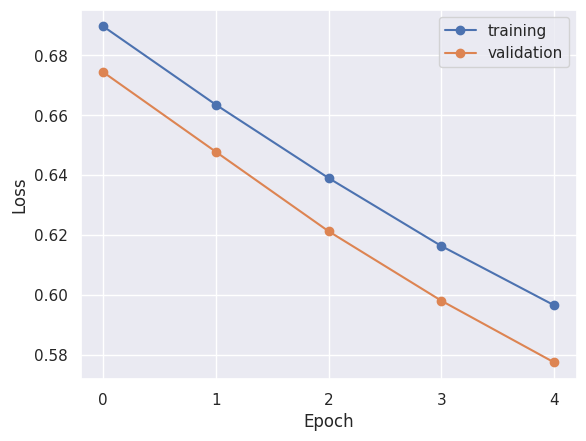

In [90]:
# text only
X_train_text_reduced = limit_vocab(X_train_text_padded, max_token_id=1000)
embeddings_model = build_embeddings_model(average_over_positions=True,
                               vocab_size=1000,
                               sequence_length=300,
                               embedding_dim=2)
history = embeddings_model.fit(
  x = X_train_text_reduced,  # our sparse padded training data
  y = y_train_text,          # corresponding binary labels
  epochs=5,             # number of passes through the training data
  batch_size=64,        # mini-batch size
  validation_split=0.1, # use a fraction of the examples for validation
  verbose=1             # display some progress output during training
  )

history = pd.DataFrame(history.history)
plot_history(history)

In [91]:
print("Train Acc:", 0.7543)
print("Validation Acc:", 0.7720)

Train Acc: 0.7543
Validation Acc: 0.772
